# Desafío 3 - PLN - 19 cohorte

**Alumno**: Jose Perez (joseperez190498@gmail.com)

### **Consigna**
* Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
* Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
* Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
* Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### **Sugerencias**

* Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
* Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

##**Resolución de la consigna**



In [ ]:
#%pip install torch plotly wordcloud nltk matplotlib pandas seaborn numpy scikit-learn tensorflow

* **Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.**

In [1]:
import numpy as np
import warnings
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Embedding, Dropout
from tensorflow.keras.utils import pad_sequences
from scipy.special import softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import json
from IPython.display import clear_output

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

In [ ]:
# Revisa si hay una GPU disponible y la configura para evitar errores de memoria.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU detectada y lista para usar: {gpus[0].name}")
  except RuntimeError as e:
    print(f"Error configurando la GPU: {e}")
else:
  print("No se detectó GPU. Revisa la configuración del entorno de ejecución.")


### **Corpus de texto**

El corpus utilizado para la resolución de la consigna se ha descargado de: https://www.gutenberg.org/cache/epub/2000/pg2000.txt. Este corpus hace referencia al libro *Don Quijote* del autor Miguel de Cervantes Saavedra.


* **Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.**


In [2]:
# Función de limpieza
def clean_text(raw_text):
    """
    Remove english words → Lowercase → Remove special chars → Remove multiple spaces
    """
    try:
      spanish_start_idx = raw_text.find('*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***')
      spanish_end_idx = raw_text.find('*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***')
      if spanish_start_idx != -1 and spanish_end_idx != -1:
        cleaned_text = text.lower()
        #
        spanish_start_idx = text.find('\n', spanish_start_idx) + 1
        cleaned_text = cleaned_text[spanish_start_idx:spanish_end_idx].strip()
        #
        cleaned_text = re.sub(r'[^a-záéíóúüñ\s]', ' ', cleaned_text)
        #
        cleaned_text = re.sub(r'\r+', ' ', cleaned_text)
        #
        return cleaned_text
    except Exception:
      pass
    return text

In [3]:
with open('don_quijote_cervantes.txt' , 'r', encoding='utf-8') as f:
    text = f.read()
    corpus_text = clean_text(text)
    print(corpus_text[:1000])

el ingenioso hidalgo don quijote de la mancha



por miguel de cervantes saavedra





el ingenioso hidalgo don quijote de la mancha


  
tasa

  
testimonio de las erratas

  
el rey

  
al duque de béjar

  
prólogo

  
al libro de don quijote de la mancha



que trata de la condición y ejercicio del famoso
hidalgo don quijote de la mancha

que trata de la primera salida que de su tierra hizo
el ingenioso don quijote

donde se cuenta la graciosa manera que tuvo don
quijote en armarse caballero

de lo que le sucedió a nuestro caballero cuando salió
de la venta

donde se prosigue la narración de la desgracia de
nuestro caballero

del donoso y grande escrutinio que el cura y el
barbero hicieron en la librería de nuestro ingenioso hidalgo

de la segunda salida de nuestro buen caballero don
quijote de la mancha

del buen suceso que el valeroso don quijote tuvo en
la espantable y jamás imaginada aventura de los molinos de viento  con
otros sucesos dignos de felice recordación

donde se con

* **Comentario**: El objetivo de la función de limpieza es, básicamente, eliminar los encabezados y pies de páginas en inglés para así tener texto únicamente en español. Estandarizar el corpus volviéndolo en minúsculas y eliminando caracteres especiales y signos de puntuación.

In [4]:
# Tokenización a nivel de caracter usando char2idx
chars = sorted(list(set(corpus_text)))
vocab_size = len(chars)
print(f"\nEl tamaño del vocabulario de caracteres es: {vocab_size}")

char2idx = {k: v for v, k in enumerate(chars)}
idx2char = {v: k for k, v in char2idx.items()}
print("char2idx", char2idx)
print("idx2char", idx2char)

vocabulary = {
  'char2idx': char2idx,
  'idx2char': idx2char
}
with open('vocabulary.json', 'w') as f:
  json.dump(vocabulary, f, indent=4)
  print("Vocabulario guardado en 'vocabulary.json'.")

tokenized_text = [char2idx[ch] for ch in corpus_text]
max_context_size = 100

# Separación en entrenamiento y validación
p_val = 0.05
num_val_chars = int(len(tokenized_text) * p_val)
train_tokens = tokenized_text[:-num_val_chars]
validation_tokens = tokenized_text[-num_val_chars:]
tokenized_sentences_val = [validation_tokens[i:i + max_context_size*2] for i in range(0, len(validation_tokens) - max_context_size*2, max_context_size*2)]

# Estructuración del dataset (many-to-one)
input_sequences, output_sequences = [], []
step = 5
for i in range(0, len(train_tokens) - max_context_size, step):
    input_sequences.append(train_tokens[i:i + max_context_size])
    output_sequences.append(train_tokens[i + max_context_size])

X = np.array(input_sequences)
y = np.array(output_sequences)
print(f"\nForma del dataset de entrenamiento X: {X.shape}")
print(f"Forma del dataset de entrenamiento y: {y.shape}")


El tamaño del vocabulario de caracteres es: 34
char2idx {'\n': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'á': 27, 'é': 28, 'í': 29, 'ñ': 30, 'ó': 31, 'ú': 32, 'ü': 33}
idx2char {0: '\n', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'á', 28: 'é', 29: 'í', 30: 'ñ', 31: 'ó', 32: 'ú', 33: 'ü'}
Vocabulario guardado en 'vocabulary.json'.

Forma del dataset de entrenamiento X: (401018, 100)
Forma del dataset de entrenamiento y: (401018,)


* **Comentario**: Se crea un vocabulario a nivel de caracter, asignando un índice numérico a cada uno, obteniendo en total un vocabulario de 34 caracteres que están presentes en el corpus. El texto se transforma en más de 400 mil ejemplos de entrenamiento. Cada ejemplo está estructurado de tal forma que el modelo aprenda a predecir el siguiente caracter (y) a partir de una secuencia de los 100 caracteres anteriores (X).

* **Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.**


In [ ]:
def build_model(model_name, vocab_size, max_len):
    """
    Esta función crea y compila un modelo Keras según el nombre especificado.
    Es un punto central para definir todas nuestras arquitecturas.
    """
    print(f"Construyendo el modelo: {model_name.upper()}...")
    model_name = model_name.lower()

    if model_name == "lstm":
        model = Sequential([
            Embedding(vocab_size, 50, input_length=max_len),
            LSTM(150),
            Dropout(0.2),
            Dense(vocab_size, activation='softmax')
        ], name="LSTM_Model")
    elif model_name == "gru":
        model = Sequential([
            Embedding(vocab_size, 50, input_length=max_len),
            GRU(150),
            Dropout(0.2),
            Dense(vocab_size, activation='softmax')
        ], name="GRU_Model")
    elif model_name == "simplernn":
        model = Sequential([
            Embedding(vocab_size, 50, input_length=max_len),
            SimpleRNN(150),
            Dropout(0.2),
            Dense(vocab_size, activation='softmax')
        ], name="SimpleRNN_Model")
    else:
        raise ValueError(f"Nombre de modelo no reconocido: '{model_name}'. Opciones válidas: 'lstm', 'gru', 'simplernn'.")

    # Compilamos el modelo con los parámetros recomendados
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

* **Comentario**: La función build_model construye dinámicamente una de las tres arquitecturas de redes neuronales recurrentes, para la prueba se utilizará simpleRNN y LSTM. La estructura de los modelos consiste en una capa de Embedding, la capa recurrente, una capa de dropout y una capa de predicción.

In [ ]:
class PplCallback(keras.callbacks.Callback):
    """
    Callback que calcula la perplejidad de validacion y la guarda en una
    lista externa para graficarla despues del entrenamiento.
    """
    def __init__(self, validation_sequences, max_len, history_list):
        super().__init__()
        self.validation_sequences = validation_sequences
        self.max_len = max_len
        self.history_list = history_list

    def on_epoch_end(self, epoch, logs=None):
        sample_sequences = self.validation_sequences[:10]
        total_log_prob, total_chars = 0, 0

        for seq in sample_sequences:
            for i in range(1, len(seq)):
                context_seq = seq[:i]
                target_char_index = seq[i]
                padded_context = pad_sequences([context_seq], maxlen=self.max_len, padding='pre')
                prediction = self.model.predict(padded_context, verbose=0)[0]
                prob_target = prediction[target_char_index]
                total_log_prob += np.log(prob_target + 1e-10)
                total_chars += 1

        if total_chars > 0:
            perplexity = np.exp(-total_log_prob / total_chars)
            print(f" - Perplejidad (Validación muestra): {perplexity:.4f}")
            self.history_list.append(perplexity)


In [ ]:
def plot_training_history(history, ppl_history):
    """
    Grafica las curvas de perdida y precision del entrenamiento.
    """
    # Extraer las metricas del objeto history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

    # Grafico para la Perdida (Loss)
    ax1.plot(epochs, loss, 'bo-', label='Pérdida (Entrenamiento)')
    ax1.plot(epochs, val_loss, 'ro-', label='Pérdida (Validación)')
    ax1.set_title('Evolución de la Pérdida', fontsize=16)
    ax1.set_xlabel('Época'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    # Grafico para la Precision (Accuracy)
    ax2.plot(epochs, accuracy, 'bo-', label='Precisión (Entrenamiento)')
    ax2.plot(epochs, val_accuracy, 'ro-', label='Precisión (Validación)')
    ax2.set_title('Evolución de la Precisión', fontsize=16)
    ax2.set_xlabel('Época'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

    # Grafico para la Perplejidad de Validacion
    ppl_epochs = range(1, len(ppl_history) + 1)
    ax3.plot(ppl_epochs, ppl_history, 'go-', label='Perplejidad (Validación)')
    ax3.set_title('Evolución de la Perplejidad', fontsize=16)
    ax3.set_xlabel('Época'); ax3.set_ylabel('Perplejidad'); ax3.legend(); ax3.grid(True)

    plt.suptitle('Curvas de Entrenamiento del Modelo', fontsize=20)
    plt.show()

Construyendo el modelo: SIMPLERNN...


Model: "SimpleRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 50)        │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 34)             │         5,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,984 (144.47 KB)

 Trainable params: 36,984 (144.47 KB)

 Non-trainable params: 0 (0.00 B)


El mejor modelo se guardará como: don_quijote_simplernn_best_model.keras

Iniciando entrenamiento...
Epoch 1/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2806 - loss: 2.4677 - Perplejidad (Validación muestra): 7.9833

Epoch 1: val_loss improved from inf to 2.07183, saving model to don_quijote_simplernn_best_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 182s 247ms/step - accuracy: 0.2806 - loss: 2.4674 - val_accuracy: 0.3614 - val_loss: 2.0718
Epoch 2/20
704/705 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3669 - loss: 2.0688 - Perplejidad (Validación muestra): 7.1002

Epoch 2: val_loss improved from 2.07183 to 1.96060, saving model to don_quijote_simplernn_best_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 156s 221ms/step - accuracy: 0.3669 - loss: 2.0687 - val_accuracy: 0.3981 - val_loss: 1.9606
Epoch 3/20
704/705 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3933 - loss: 1.9795 - Perplejidad (Validación muestra): 6.6371

Epoch 3: val_loss improved from 1.96060 to 1.88001, s

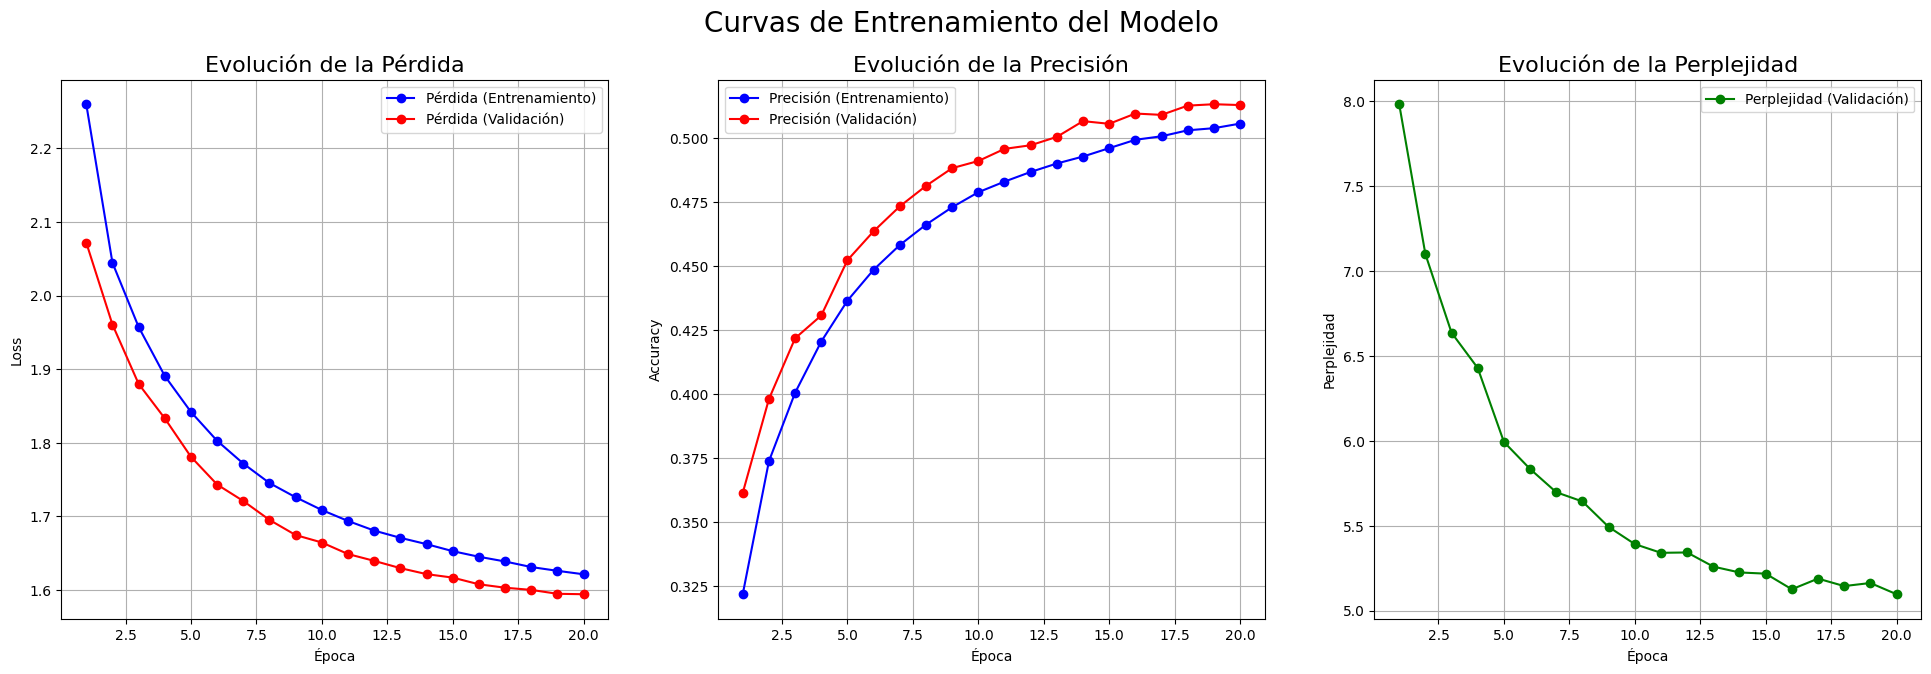

In [ ]:
# ----- SimpleRNN -----

if 'X' in locals():
    MODEL_TYPE  = "SimpleRNN"  # Opciones: "GRU", "SimpleRNN", "LSTM"

    # 1. Construimos el modelo
    model = build_model(MODEL_TYPE , vocab_size, max_context_size)
    model.build(input_shape=(None, max_context_size))
    model.summary()

    # 2. Creamos el nombre del archivo dinámicamente
    model_filename = f"don_quijote_{MODEL_TYPE.lower()}_best_model.keras"
    print(f"\nEl mejor modelo se guardará como: {model_filename}")

    # 3. Creamos los callbacks
    checkpoint_callback = ModelCheckpoint(
        filepath=model_filename,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    ppl_history = []
    ppl_callback = PplCallback(tokenized_sentences_val, max_context_size, ppl_history)

    # 4. Iniciamos el entrenamiento
    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=20,
        batch_size=512,
        validation_split=0.1,
        callbacks=[ppl_callback, checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    print(f"\nEntrenamiento completado. El mejor modelo ha sido guardado en '{model_filename}'.")


    # 4. Guardar el historial de Keras (loss, accuracy, etc.)
    keras_history_filename = f"don_quijote_{MODEL_TYPE.lower()}_keras_history.json"
    history_for_json = {key: [float(value) for value in values] for key, values in history.history.items()}
    with open(keras_history_filename, 'w') as f:
        # El objeto history.history ya es un diccionario serializable
        json.dump(history_for_json, f, indent=4)
    print(f"Historial de Keras guardado en '{keras_history_filename}'.")

    # 5. Guardar el historial de perplejidad
    ppl_history_filename = f"don_quijote_{MODEL_TYPE.lower()}_perplexity_history.json"
    # Creamos un diccionario para guardar la lista
    ppl_history_to_save = {'validation_perplexity': [float(p) for p in ppl_history]}
    with open(ppl_history_filename, 'w') as f:
        json.dump(ppl_history_to_save, f, indent=4)
    print(f"Historial de Perplejidad guardado en '{ppl_history_filename}'.")

    # 6. Graficamos el historial guardado
    plot_training_history(history, ppl_history)


* **Comentario**: Se observa el entrenamiento del modelo simpleRNN con una mejora constante tanto en las métricas de entrenamiento como en las de validación, el *accuracy* aumenta de manera sostenida mientras que el *loss* y la *perplexity* disminuyen consistentemente en cada época. Esto nos da a entender que el modelo está aprendiendo los patrones del texto y está generalizando bien, además no hay signos evidentes de sobrajuste en las 20 *epochs*.

Construyendo el modelo: LSTM...


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         5,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,434 (497.79 KB)

 Trainable params: 127,434 (497.79 KB)

 Non-trainable params: 0 (0.00 B)


El mejor modelo se guardará como: don_quijote_lstm_best_model.keras

Iniciando entrenamiento...
Epoch 1/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2595 - loss: 2.5805 - Perplejidad (Validación muestra): 7.8882

Epoch 1: val_loss improved from inf to 2.07584, saving model to don_quijote_lstm_best_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 157s 217ms/step - accuracy: 0.2595 - loss: 2.5801 - val_accuracy: 0.3579 - val_loss: 2.0758
Epoch 2/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3713 - loss: 2.0461 - Perplejidad (Validación muestra): 6.7720

Epoch 2: val_loss improved from 2.07584 to 1.90898, saving model to don_quijote_lstm_best_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 201s 221ms/step - accuracy: 0.3714 - loss: 2.0461 - val_accuracy: 0.4113 - val_loss: 1.9090
Epoch 3/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4145 - loss: 1.9050 - Perplejidad (Validación muestra): 6.1163

Epoch 3: val_loss improved from 1.90898 to 1.80695, saving model to 

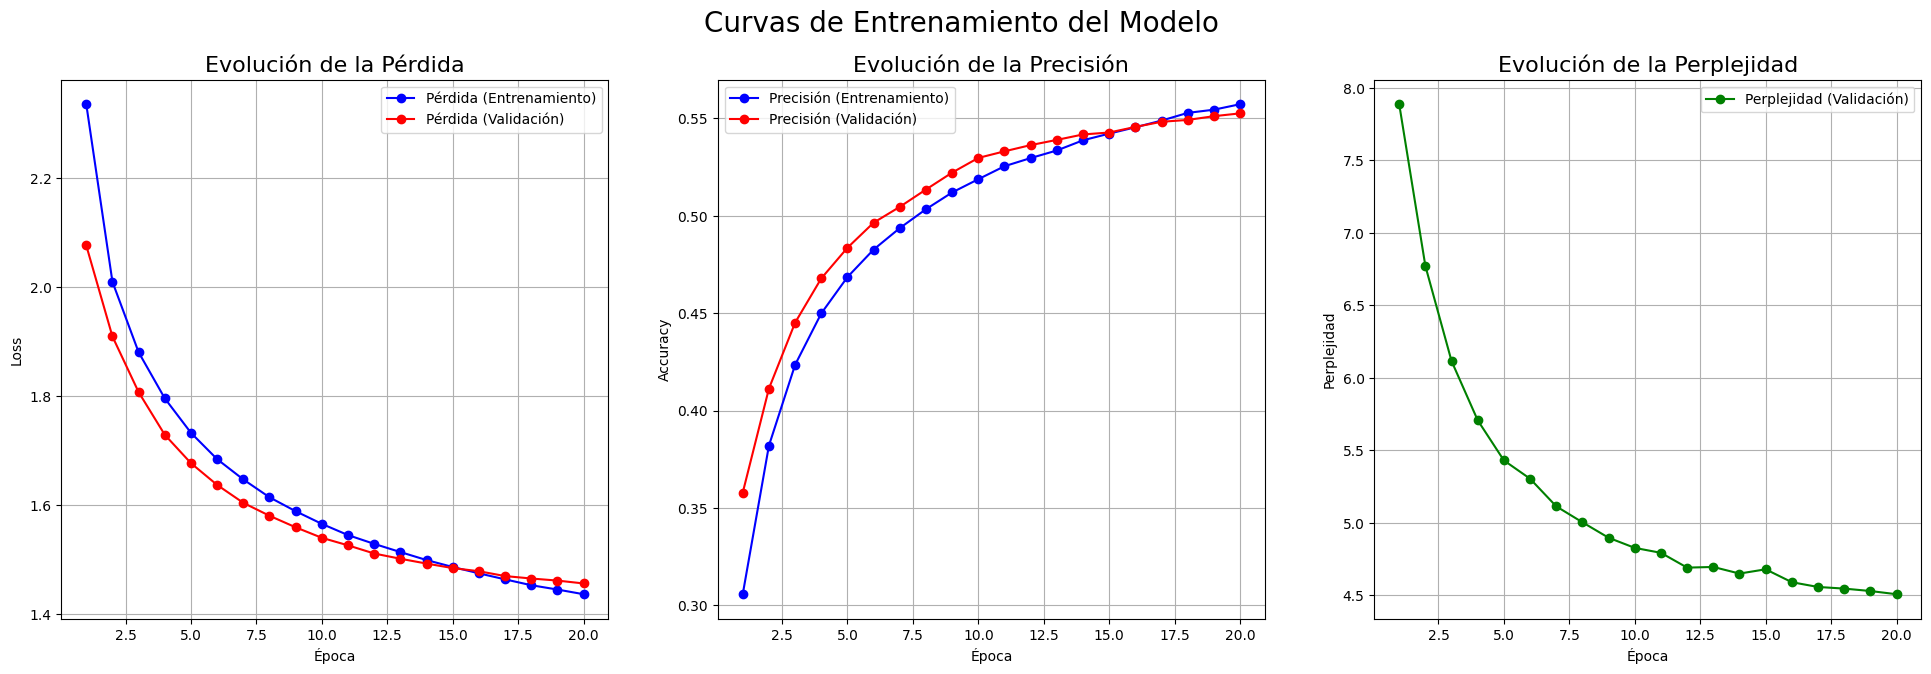

In [ ]:
# ----- LSTM -----

if 'X' in locals():
    MODEL_TYPE  = "LSTM"  # Opciones: "GRU", "SimpleRNN", "LSTM"

    # 1. Construimos el modelo
    model = build_model(MODEL_TYPE , vocab_size, max_context_size)
    model.build(input_shape=(None, max_context_size))
    model.summary()

    # 2. Creamos el nombre del archivo dinámicamente
    model_filename = f"don_quijote_{MODEL_TYPE.lower()}_best_model.keras"
    print(f"\nEl mejor modelo se guardará como: {model_filename}")

    # 3. Creamos los callbacks
    checkpoint_callback = ModelCheckpoint(
        filepath=model_filename,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    ppl_history = []
    ppl_callback = PplCallback(tokenized_sentences_val, max_context_size, ppl_history)

    # 4. Iniciamos el entrenamiento
    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=20,
        batch_size=512,
        validation_split=0.1,
        callbacks=[ppl_callback, checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    print(f"\nEntrenamiento completado. El mejor modelo ha sido guardado en '{model_filename}'.")


    # 4. Guardar el historial de Keras (loss, accuracy, etc.)
    keras_history_filename = f"don_quijote_{MODEL_TYPE.lower()}_keras_history.json"
    history_for_json = {key: [float(value) for value in values] for key, values in history.history.items()}
    with open(keras_history_filename, 'w') as f:
        # El objeto history.history ya es un diccionario serializable
        json.dump(history_for_json, f, indent=4)
    print(f"Historial de Keras guardado en '{keras_history_filename}'.")

    # 5. Guardar el historial de perplejidad
    ppl_history_filename = f"don_quijote_{MODEL_TYPE.lower()}_perplexity_history.json"
    # Creamos un diccionario para guardar la lista
    ppl_history_to_save = {'validation_perplexity': [float(p) for p in ppl_history]}
    with open(ppl_history_filename, 'w') as f:
        json.dump(ppl_history_to_save, f, indent=4)
    print(f"Historial de Perplejidad guardado en '{ppl_history_filename}'.")

    # 6. Graficamos el historial guardado
    plot_training_history(history, ppl_history)


* **Comentario**: El entrenamiento del modelo LSTM muestra un rendimiento mayor al de SimpleRNN. El model summary revela que el LSTM tiene significativamente más parámetros, lo que otorga al modelo una mayor capacidad de aprendizaje. Alcanza un *accuracy* de 55.3% en 20 épocas, superando al 51.3% de simpleRNN. El *val_loss* y la *perplexity* tambien alcanzan valores consistentemente más bajos, lo que indica predicciones más acertadas y seguras.

* **Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.**

In [5]:
def greedy_search_generator(model, seed_text, n_chars, max_len, char_map, int_map):
    """
    Genera texto usando la estrategia Greedy Search, caracter por caracter.
    """
    generated_text = seed_text.lower()
    for _ in range(n_chars):
        encoded_sequence = [char_map.get(c, 0) for c in generated_text]
        padded_sequence = pad_sequences([encoded_sequence], maxlen=max_len, padding='pre')

        # Predice el siguiente caracter y elige el mas probable (greedy)
        predicted_index = np.argmax(model.predict(padded_sequence, verbose=0))

        generated_text += int_map.get(predicted_index, '')

    return generated_text


In [6]:
def select_beam_search_candidates(predictions, prev_sequences, beam_width, temp, stochastic, vocab_size):
    """
    Funcion auxiliar para Beam Search.
    Toma las predicciones y las secuencias anteriores para seleccionar los
    mejores nuevos candidatos.
    """
    all_candidates = []
    # Itera sobre cada secuencia candidata previa (beam)
    for i in range(len(prev_sequences)):
        sequence, score = prev_sequences[i]
        preds = predictions[i]

        if stochastic:
            # Muestreo con temperatura para la seleccion estocastica
            preds = np.asarray(preds).astype('float64')
            preds = np.log(preds + 1e-10) / temp
            exp_preds = np.exp(preds)
            probabilities = exp_preds / np.sum(exp_preds)
            top_indices = np.random.choice(range(vocab_size), beam_width, p=probabilities, replace=False)
        else:
            # Seleccion determinista de los mejores
            probabilities = preds
            top_indices = np.argsort(probabilities)[-beam_width:]

        # Crea un nuevo candidato para cada una de las mejores predicciones
        for index in top_indices:
            # El nuevo score es la suma de log-probabilidades
            candidate = [sequence + [index], score - np.log(probabilities[index])]
            all_candidates.append(candidate)

    # Ordena todos los candidatos generados y devuelve los mejores 'beam_width'
    ordered_candidates = sorted(all_candidates, key=lambda x: x[1])
    return ordered_candidates[:beam_width]

def beam_search_generator(model, seed_text, n_chars, max_len, beam_width, temp, stochastic, char_map, int_map, vocab_size):
    """
    Genera texto usando Beam Search.
    Devuelve una lista de los textos generados con sus scores.
    """
    start_sequence = [char_map.get(c, 0) for c in seed_text.lower()]
    # La estructura de cada secuencia es: [lista_de_indices, score_log_prob]
    current_sequences = [[start_sequence, 0.0]]

    for _ in range(n_chars):
        predictions = []
        for seq, score in current_sequences:
            padded = pad_sequences([seq], maxlen=max_len, padding='pre')
            predictions.append(model.predict(padded, verbose=0)[0])

        current_sequences = select_beam_search_candidates(predictions, current_sequences, beam_width, temp, stochastic, vocab_size)

    # Decodifica las secuencias finales de indices a texto
    final_texts = []
    for seq, score in current_sequences:
        text = ''.join([int_map.get(i, '') for i in seq])
        final_texts.append({'score': score, 'text': text})

    return final_texts

In [7]:
import os
from tensorflow.keras.models import load_model

model_filename = "don_quijote_simplernn_best_model.keras"
seed_text = "en un lugar de la mancha"
max_context_length = 100

# Cargar vocabulario
with open('vocabulary.json', 'r') as f:
  vocabulary = json.load(f)

char2idx = vocabulary['char2idx']
idx2char = {int(k): v for k, v in vocabulary['idx2char'].items()}
vocab_size = len(char2idx)

# Carga el modelo completo desde el archivo
loaded_model = load_model(model_filename)
print("¡Modelo cargado exitosamente!")

print("\n" + "="*80)
print("INICIANDO GENERACIÓN DE TEXTO CON EL MODELO ENTRENADO")
print(model_filename)
print("="*80)

# --- Prueba 1: Greedy Search ---
print("\n--- [Prueba 1: Greedy Search] ---")
greedy_result = greedy_search_generator(loaded_model, seed_text, 200, max_context_length, char2idx, idx2char)
print(greedy_result)

# --- Prueba 2: Beam Search Determinista ---
print("\n" + "-"*80)
print("--- [Prueba 2: Beam Search Determinista (beam_width=3)] ---")
deterministic_results = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=1.0, stochastic=False, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(deterministic_results):
    print(f"  Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# --- Prueba 3: Beam Search Estocástico (Temperaturas) ---
print("\n" + "-"*80)
print("--- [Prueba 3: Beam Search Estocástico (beam_width=3)] ---")

# Temperatura Baja
print("\n  [Temperatura = 0.5 - Texto más conservador]")
stochastic_results_low_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=0.5, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_low_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# Temperatura Media
print("\n  [Temperatura = 1.2 - Texto más equilibrado]")
stochastic_results_mid_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=1.2, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_mid_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# Temperatura Alta
print("\n  [Temperatura = 2.0 - Texto más aleatorio]")
stochastic_results_high_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=2.0, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_high_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

print("\n" + "="*80)
print("FIN DE LAS PRUEBAS DE GENERACIÓN")
print("="*80)

¡Modelo cargado exitosamente!

INICIANDO GENERACIÓN DE TEXTO CON EL MODELO ENTRENADO
don_quijote_simplernn_best_model.keras

--- [Prueba 1: Greedy Search] ---
en un lugar de la mancha  y de la caballero  y  por esto  y al caballero  y  por esto  y al caballero  y  por esto  y al caballero  y  por esto  y al caballero  y  por esto  y al caballero  y  por esto  y al caballero  y  po

--------------------------------------------------------------------------------
--- [Prueba 2: Beam Search Determinista (beam_width=3)] ---
  Opción 1 (Score: 35.09): en un lugar de la mancha  que en el caballero  porque no se le dijo el cab
  Opción 2 (Score: 35.17): en un lugar de la mancha  que en el caballero  porque no se le dijo el cua
  Opción 3 (Score: 35.76): en un lugar de la mancha  que en el caballero  porque no se le dijo el cue

--------------------------------------------------------------------------------
--- [Prueba 3: Beam Search Estocástico (beam_width=3)] ---

  [Temperatura = 0.5 - Tex

In [8]:
import os
from tensorflow.keras.models import load_model

model_filename = "don_quijote_lstm_best_model.keras"
seed_text = "en un lugar de la mancha"
max_context_length = 100

# Cargar vocabulario
with open('vocabulary.json', 'r') as f:
  vocabulary = json.load(f)

char2idx = vocabulary['char2idx']
idx2char = {int(k): v for k, v in vocabulary['idx2char'].items()}
vocab_size = len(char2idx)

# Carga el modelo completo desde el archivo
loaded_model = load_model(model_filename)
print("¡Modelo cargado exitosamente!")

print("\n" + "="*80)
print("INICIANDO GENERACIÓN DE TEXTO CON EL MODELO ENTRENADO")
print(model_filename)
print("="*80)

# --- Prueba 1: Greedy Search ---
print("\n--- [Prueba 1: Greedy Search] ---")
greedy_result = greedy_search_generator(loaded_model, seed_text, 200, max_context_length, char2idx, idx2char)
print(greedy_result)

# --- Prueba 2: Beam Search Determinista ---
print("\n" + "-"*80)
print("--- [Prueba 2: Beam Search Determinista (beam_width=3)] ---")
deterministic_results = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=1.0, stochastic=False, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(deterministic_results):
    print(f"  Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# --- Prueba 3: Beam Search Estocástico (Temperaturas) ---
print("\n" + "-"*80)
print("--- [Prueba 3: Beam Search Estocástico (beam_width=3)] ---")

# Temperatura Baja
print("\n  [Temperatura = 0.5 - Texto más conservador]")
stochastic_results_low_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=0.5, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_low_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# Temperatura Media
print("\n  [Temperatura = 1.2 - Texto más equilibrado]")
stochastic_results_mid_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=1.2, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_mid_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

# Temperatura Alta
print("\n  [Temperatura = 2.0 - Texto más aleatorio]")
stochastic_results_high_temp = beam_search_generator(loaded_model, seed_text, 50, max_context_length, beam_width=3, temp=2.0, stochastic=True, char_map=char2idx, int_map=idx2char, vocab_size=vocab_size)
for i, result in enumerate(stochastic_results_high_temp):
    print(f"    Opción {i+1} (Score: {result['score']:.2f}): {result['text']}")

print("\n" + "="*80)
print("FIN DE LAS PRUEBAS DE GENERACIÓN")
print("="*80)

¡Modelo cargado exitosamente!

INICIANDO GENERACIÓN DE TEXTO CON EL MODELO ENTRENADO
don_quijote_lstm_best_model.keras

--- [Prueba 1: Greedy Search] ---
en un lugar de la mancha  y  a lo que estaba en la caballería  y  con esto  sin de la caballería  y  con esto  sin de la caballería  y  con esto  sin de la caballería  y  con esto  sin de la caballería  y  con esto  sin de l

--------------------------------------------------------------------------------
--- [Prueba 2: Beam Search Determinista (beam_width=3)] ---
  Opción 1 (Score: 25.19): en un lugar de la mancha 

  señor don quijote de los caballeros andantes 
  Opción 2 (Score: 28.22): en un lugar de la mancha 

  señor don quijote de los caballeros andantes

  Opción 3 (Score: 29.12): en un lugar de la mancha 

  señor don quijote de los caballeros de los ca

--------------------------------------------------------------------------------
--- [Prueba 3: Beam Search Estocástico (beam_width=3)] ---

  [Temperatura = 0.5 - Texto má

* **Comentario**:  

Greedy Search muestra su debilidad clásica al caer rápidamente en un bucle repetitivo, demostrando por qué se necesitan métodos más avanzados.

Por otro lado, Beam Search Determinista mejora los resultados, generando una frase larga, coherente y contextualizada en el universo de Don Quijote.

Beam Search Estocástico ilustran a la perfección el rol de la temperatura: con un valor bajo (0.5) el texto es conservador y muy apegado a los temas centrales del libro; con un valor medio (1.2) gana creatividad y variedad léxica a costa de un poco de coherencia; y con un valor alto (2.0) la aleatoriedad domina, generando un texto más *random*. En conjunto, estas pruebas validan que el modelo ha aprendido patrones complejos y demuestran el control que tenemos sobre la calidad del texto generado.

### **Conclusiones**

Si bien nuestro corpus, al consistir en una única obra, presenta una temática y un estilo muy homogéneos, el entrenamiento ha resultado un ejercicio excelente para evaluar distintas arquitecturas y estrategias de generación. Los resultados demuestran que el modelo LSTM es superior para esta tarea en comparación al modelo simpleRNN, gracias a su capacidad para gestionar una memoria a más largo plazo y capturar las complejas reglas del texto.

Se comprobó además que la estrategia de generación es igualmente crucial, donde Beam Search produjo secuencias coherentes, superando a Greedy Search que tiende a caer en bucles repetitivos. Finalmente, la temperatura en el muestreo estocástico demostró ser una herramienta clave para controlar el equilibrio entre lo conservador y aleatorio.
